In [ ]:
#!conda install -c conda-forge gdcm -y

In [ ]:
#%cd ../input/python3gdcm
!dpkg -i ../input/python3gdcm/build_1-1_amd64.deb
!apt-get install -f

In [ ]:
!cp /usr/local/lib/gdcm.py /opt/conda/lib/python3.7/site-packages/.
!cp /usr/local/lib/gdcmswig.py /opt/conda/lib/python3.7/site-packages/.
!cp /usr/local/lib/_gdcmswig.so /opt/conda/lib/python3.7/site-packages/.
!cp /usr/local/lib/libgdcm* /opt/conda/lib/python3.7/site-packages/.
!ldconfig

In [ ]:
import os
import cv2
import sys
import random
import pickle
import glob
import gc
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gdcm
import pydicom

import scipy.ndimage as ndimage
from scipy.ndimage import zoom
from scipy.stats import kurtosis
from scipy.stats import skew

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import warnings
warnings.filterwarnings("ignore")

In [ ]:
sys.path.append('../input/efficientnet-pytorch/EfficientNet-PyTorch-master')
sys.path.append('../input/pretrainedmodels/pretrainedmodels-0.7.4/')
sys.path.append('../input/segmentation-models-pytorch/')
import segmentation_models_pytorch as smp

* CT Image Preprocessing

The size of the images are not uniform, need to unify them to 512*521

In [ ]:
dicom_root_path = '../input/osic-pulmonary-fibrosis-progression/train/'
Patients_id = os.listdir(dicom_root_path)
n_dicom_dict = {"Patient":[],"n_dicom":[],"list_dicom":[]}

for Patient_id in Patients_id:
    dicom_id_path = glob.glob(dicom_root_path + Patient_id + "/*")
    n_dicom_dict["n_dicom"].append(len(dicom_id_path))
    n_dicom_dict["Patient"].append(Patient_id)
    list_dicom_id = sorted([int(i.split("/")[-1][:-4]) for i in dicom_id_path])
    n_dicom_dict["list_dicom"].append(list_dicom_id)

dicom_pd = pd.DataFrame(n_dicom_dict)

In [ ]:
dicom_pd['height'],dicom_pd['width'] = -1,-1
for Patient_id in Patients_id:
    dicom_id_path = glob.glob(dicom_root_path + Patient_id + "/*")
    for patient_dicom_id_path in dicom_id_path:
        dicom = pydicom.dcmread(patient_dicom_id_path)
        dicom_pd.loc[dicom_pd.Patient==Patient_id,'height'] = dicom.Rows
        dicom_pd.loc[dicom_pd.Patient==Patient_id,'width'] = dicom.Columns
        break

In [ ]:
reshape_dicom_pd = dicom_pd.loc[(dicom_pd.height!=512) | (dicom_pd.width!=512),:]
reshape_dicom_pd = reshape_dicom_pd.reset_index(drop=True)
reshape_dicom_pd.head()

In [ ]:
crop_id = ['ID00240637202264138860065','ID00122637202216437668965','ID00086637202203494931510',
            'ID00419637202311204720264','ID00014637202177757139317','ID00094637202205333947361',
            'ID00067637202189903532242',]
reshape_dicom_pd['resize_type'] = 'resize'
reshape_dicom_pd.loc[reshape_dicom_pd.Patient.isin(crop_id),'resize_type'] = 'crop'

In [ ]:
dicom_pd['resize_type'] = 'no'
for idx,i in enumerate(reshape_dicom_pd['Patient']):
    dicom_pd.loc[dicom_pd.Patient==i,'resize_type'] = reshape_dicom_pd.loc[idx,'resize_type']
dicom_pd.head()

ps:Some patients were tested FVC more than once a week

In [ ]:
train_pd = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
temp_pd = pd.DataFrame(columns=train_pd.columns)
for i in range(len(dicom_pd)):
    patient_pd = train_pd[train_pd.Patient==dicom_pd.iloc[i].Patient]
    zeroweek = patient_pd['Weeks'].min()
    #if sum(patient_pd.Weeks==zeroweek)>1:
    #    print(pd.unique(patient_pd.Patient))
    temp_pd = temp_pd.append(patient_pd[patient_pd.Weeks==zeroweek].iloc[0])
dicom_pd = pd.merge(dicom_pd, temp_pd, on=['Patient'])
dicom_pd.head()

In [ ]:
dicom_pd[dicom_pd.resize_type!='no'].head()

In [ ]:
def load_scan(path,resize_type='no'):
    """
    Loads scans from a folder and into a list.
    
    Parameters: path (Folder path)
    
    Returns: slices (List of slices)
    """
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = abs(slices[-1].ImagePositionPatient[2] - slices[0].ImagePositionPatient[2])/(len(slices))
    except:
        try:
            slice_thickness = abs(slices[-1].SliceLocation - slices[0].SliceLocation)/(len(slices))
        except:
            slice_thickness = slices[0].SliceThickness
        
    for s in slices:
        s.SliceThickness = slice_thickness
        if resize_type == 'resize':
            s.PixelSpacing = s.PixelSpacing*(s.Rows/512)  
    return slices

In [ ]:
def transform_to_hu(slices):
    """
    transform dicom.pixel_array to Hounsfield.
    Parameters: list dicoms
    Returns:numpy Hounsfield
    """
    
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    # convert ouside pixel-values to air:
    # I'm using <= -1000 to be sure that other defaults are captured as well
    #images[images <= -1000] = 0
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

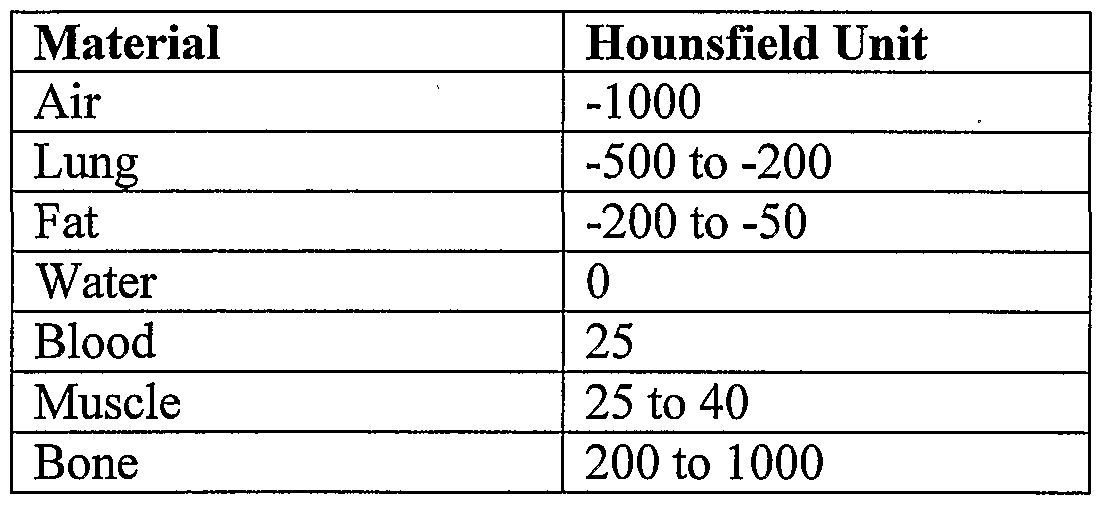

In [ ]:
def crop_image(img: np.ndarray):
    edge_pixel_value = img[0, 0]
    mask = img != edge_pixel_value
    return img[np.ix_(mask.any(1),mask.any(0))]

def resize_image(img: np.ndarray,reshape=(512,512)):
    img = cv2.resize(img,(512,512))
    return img

def preprocess_img(img,resize_type):
    if resize_type == 'resize':
        img = [resize_image(im) for im in img]
    if resize_type == 'crop':
        img = [crop_image(im) for im in img]
        
    return np.array(img, dtype=np.int64)

In [ ]:
class Test_Generate(Dataset):
    def __init__(self,imgs_dicom,resize_type='no'):
        self.imgs_dicom = imgs_dicom
        self.resize_type = resize_type
    def __getitem__(self,index):
        
        slice_img = self.imgs_dicom[index].pixel_array
        slice_img = (slice_img-slice_img.min())/(slice_img.max()-slice_img.min())
        slice_img = (slice_img*255).astype(np.uint8)
        if self.resize_type == 'crop':
            slice_img = crop_image(slice_img)
        elif self.resize_type == 'resize':
            slice_img = cv2.resize(slice_img,(512,512))
            
        slice_img = slice_img[None,:,:]
        slice_img = (slice_img/255).astype(np.float32)
        return slice_img
        
    def __len__(self):
        return len(self.imgs_dicom)

the model has been trained from [this](https://www.kaggle.com/hfutybx/unet-densenet121-lung-of-segmentation)

In [ ]:
device =  torch.device('cuda:0')
model = smp.Unet('densenet121', classes=1, in_channels=1,activation='sigmoid',encoder_weights=None).to(device)
model.load_state_dict(torch.load('../input/2020osic/best_lung_Unet_densenet121.pth'))
batch = 8

def Unet_mask(model: nn.Module,input_data: DataLoader):
    model.eval()
    outs = []
    for idx, sample in enumerate(test_loader):
        image = sample
        image = image.to(device)
        with torch.no_grad():
            out = model(image)
        out = out.cpu().data.numpy()
        out = np.where(out>0.5,1,0)
        out = np.squeeze(out,axis=1)
        outs.append(out)

    outs = np.concatenate(outs)
    return outs

In [ ]:
#thresh = [-500,0]
f, ax = plt.subplots(4,2, figsize=(14, 14))

for i in range(4):
    path = os.path.join(dicom_root_path,dicom_pd.iloc[i].Patient)
    patient_scans = load_scan(path)
    
    test_db = Test_Generate(patient_scans,dicom_pd.iloc[i].resize_type)
    test_loader = DataLoader(test_db, batch_size=batch, shuffle=False, num_workers=4)
    
    masks = Unet_mask(model,test_loader)
    
    #patient_images = transform_to_hu(patient_scans)
    
    #patient_images = preprocess_img(patient_images,dicom_pd.iloc[i])
    
    num_slices = len(masks)
    patient_image = test_db[num_slices//2][0]
    patient_mask = masks[num_slices//2]
    
    #Mask = generate_internal_mask(patient_image)
    
    ax[i,0].set_title(f"{dicom_pd.iloc[i].Patient}-{dicom_pd.iloc[i].FVC}")
    ax[i,0].imshow(patient_image,cmap='gray')
    ax[i,1].imshow(patient_mask)
    
plt.show()
plt.close()

histogram of CT image

In [ ]:
thresh = [-500,-50]
f, ax = plt.subplots(2,2, figsize=(18, 18))
for i in range(4):
    path = os.path.join(dicom_root_path,dicom_pd.iloc[i].Patient)
    patient_scans = load_scan(path)
    
    test_db = Test_Generate(patient_scans,dicom_pd.iloc[i].resize_type)
    test_loader = DataLoader(test_db, batch_size=batch, shuffle=False, num_workers=4)
    
    masks = Unet_mask(model,test_loader)
    
    patient_images = transform_to_hu(patient_scans)
    patient_images = preprocess_img(patient_images,dicom_pd.loc[i,'resize_type'])
    
    num_slices = len(patient_images)
    patient_images = patient_images[int(num_slices*0.1):int(num_slices*0.9)]
    patient_masks = masks[int(num_slices*0.1):int(num_slices*0.9)]
    
    #patient_images = patient_images[num_slices//2]
    #patient_masks = pool.map(generate_internal_mask,patient_images)
   # patient_masks = patient_masks[int(num_slices*0.1):int(num_slices*0.9)]
    patient_images = patient_masks*patient_images
    
    patient_images_mean = np.mean(patient_images,0)
    
    s_pixel = patient_images_mean.flatten()
    s_pixel = s_pixel[np.where((s_pixel>thresh[0])&(s_pixel<thresh[1]))]
    
    ax[i//2,i%2].set_title(f"{dicom_pd.iloc[i].Patient}-{dicom_pd.iloc[i].FVC}")
    ax[i//2,i%2].hist(s_pixel, bins=20)

plt.show()

In [ ]:
#def func_volume(patient_scan,patient_mask):
    

def caculate_lung_volume(patient_scans,patient_masks):
    """
    caculate volume of lung from mask
    Parameters: list dicom scans,list patient CT Mask
    Returns: volume cm³　(float)
    """
    lung_volume = 0
    for i in range(len(patient_masks)):
        
        pixel_spacing = patient_scans[i].PixelSpacing
        slice_thickness = patient_scans[i].SliceThickness
        lung_volume += np.count_nonzero(patient_masks[i])*pixel_spacing[0]*pixel_spacing[1]*slice_thickness
        
    return lung_volume*0.001

In [ ]:
def caculate_histgram_statistical(patient_images,patient_masks,thresh = [-500,-50]):
    """
    caculate hisgram kurthosis of lung hounsfield
    Parameters: list patient CT image 512*512,thresh divide lung
    Returns: histgram statistical characteristic(Mean,Skew,Kurthosis)
    """
    statistical_characteristic = dict(Mean=0,Skew=0,Kurthosis=0)
    num_slices = len(patient_images)
    
    patient_images = patient_images[int(num_slices*0.1):int(num_slices*0.9)]
    patient_masks = patient_masks[int(num_slices*0.1):int(num_slices*0.9)]
    patient_images = patient_masks*patient_images
    patient_images_mean = np.mean(patient_images,0)
    
    s_pixel = patient_images_mean.flatten()
    s_pixel = s_pixel[np.where((s_pixel)>thresh[0]&(s_pixel<thresh[1]))]
    
    statistical_characteristic['Mean'] = np.mean(s_pixel)
    statistical_characteristic['Skew'] = skew(s_pixel)
    statistical_characteristic['Kurthosis'] = kurtosis(s_pixel)
    
    return statistical_characteristic

In [ ]:
lung_stat_pd = pd.DataFrame(columns=['Patient','Volume','Mean','Skew','Kurthosis'])

for i in tqdm(range(len(dicom_pd))):
    path = os.path.join(dicom_root_path,dicom_pd.iloc[i].Patient)
    lung_stat_pd.loc[i,'Patient'] = dicom_pd.iloc[i].Patient
    patient_scans = load_scan(path)
    
    test_db = Test_Generate(patient_scans,dicom_pd.iloc[i].resize_type)
    test_loader = DataLoader(test_db, batch_size=batch, shuffle=False, num_workers=4)
    masks = Unet_mask(model,test_loader)
    
    
    patient_images = transform_to_hu(patient_scans)
    patient_images = preprocess_img(patient_images,dicom_pd.loc[i,'resize_type'])
    
    lung_stat_pd.loc[i,'Volume'] = caculate_lung_volume(patient_scans,masks)                           
    #patient_images = resize_image(patient_images) if dicom_pd.iloc[i].resize_type=='resize' else patient_images
    #patient_images = resize_image(patient_masks) if dicom_pd.iloc[i].resize_type=='resize' else patient_images
    
    statistical_characteristic = caculate_histgram_statistical(patient_images,masks)
    lung_stat_pd.loc[i,'Mean'] = statistical_characteristic['Mean']
    lung_stat_pd.loc[i,'Skew'] = statistical_characteristic['Skew']
    lung_stat_pd.loc[i,'Kurthosis'] = statistical_characteristic['Kurthosis']

lung_stat_pd.head()

In [ ]:
dicom_feature = pd.merge(dicom_pd, lung_stat_pd, on=['Patient'])

Volume is 3000~4000ml is normal

In [ ]:
dicom_feature = dicom_feature.drop(['list_dicom', 'height','width','resize_type','n_dicom'], axis=1)
dicom_feature.head(20)

In [ ]:
dicom_feature.to_csv('./CT_feature_train.csv',index=False)

I try my best to caculate Volume of lung from CT.Now the version volume is accurate enough, but I don't know if Mean,Skew,Kurthosis include method is right

In [ ]:
dicom_root_path = '../input/osic-pulmonary-fibrosis-progression/test/'
Patients_id = os.listdir(dicom_root_path)
n_dicom_dict = {"Patient":[],"n_dicom":[],"list_dicom":[]}

for Patient_id in Patients_id:
    dicom_id_path = glob.glob(dicom_root_path + Patient_id + "/*")
    n_dicom_dict["n_dicom"].append(len(dicom_id_path))
    n_dicom_dict["Patient"].append(Patient_id)
    list_dicom_id = sorted([int(i.split("/")[-1][:-4]) for i in dicom_id_path])
    n_dicom_dict["list_dicom"].append(list_dicom_id)

dicom_pd = pd.DataFrame(n_dicom_dict)

In [ ]:
dicom_pd['height'],dicom_pd['width'] = -1,-1
for Patient_id in Patients_id:
    dicom_id_path = glob.glob(dicom_root_path + Patient_id + "/*")
    for patient_dicom_id_path in dicom_id_path:
        dicom = pydicom.dcmread(patient_dicom_id_path)
        dicom_pd.loc[dicom_pd.Patient==Patient_id,'height'] = dicom.Rows
        dicom_pd.loc[dicom_pd.Patient==Patient_id,'width'] = dicom.Columns
        break

In [ ]:
reshape_dicom_pd = dicom_pd.loc[(dicom_pd.height!=512) | (dicom_pd.width!=512),:]
reshape_dicom_pd = reshape_dicom_pd.reset_index(drop=True)
reshape_dicom_pd.head()

In [ ]:
crop_id = ['ID00240637202264138860065','ID00122637202216437668965','ID00086637202203494931510',
            'ID00419637202311204720264','ID00014637202177757139317','ID00094637202205333947361',
            'ID00067637202189903532242',]
reshape_dicom_pd['resize_type'] = 'resize'
reshape_dicom_pd.loc[reshape_dicom_pd.Patient.isin(crop_id),'resize_type'] = 'crop'

In [ ]:
dicom_pd['resize_type'] = 'no'
for idx,i in enumerate(reshape_dicom_pd['Patient']):
    dicom_pd.loc[dicom_pd.Patient==i,'resize_type'] = reshape_dicom_pd.loc[idx,'resize_type']
dicom_pd.head()

In [ ]:
train_pd = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
temp_pd = pd.DataFrame(columns=train_pd.columns)
for i in range(len(dicom_pd)):
    patient_pd = train_pd[train_pd.Patient==dicom_pd.iloc[i].Patient]
    zeroweek = patient_pd['Weeks'].min()
    #if sum(patient_pd.Weeks==zeroweek)>1:
    #    print(pd.unique(patient_pd.Patient))
    temp_pd = temp_pd.append(patient_pd[patient_pd.Weeks==zeroweek].iloc[0])
dicom_pd = pd.merge(dicom_pd, temp_pd, on=['Patient'])
dicom_pd.head()

In [ ]:
#thresh = [-500,0]
f, ax = plt.subplots(4,2, figsize=(14, 14))

for i in range(4):
    path = os.path.join(dicom_root_path,dicom_pd.iloc[i].Patient)
    patient_scans = load_scan(path)
    
    test_db = Test_Generate(patient_scans,dicom_pd.iloc[i].resize_type)
    test_loader = DataLoader(test_db, batch_size=batch, shuffle=False, num_workers=4)
    
    masks = Unet_mask(model,test_loader)
    
    #patient_images = transform_to_hu(patient_scans)
    
    #patient_images = preprocess_img(patient_images,dicom_pd.iloc[i])
    
    num_slices = len(masks)
    patient_image = test_db[num_slices//2][0]
    patient_mask = masks[num_slices//2]
    
    #Mask = generate_internal_mask(patient_image)
    
    ax[i,0].set_title(f"{dicom_pd.iloc[i].Patient}-{dicom_pd.iloc[i].FVC}")
    ax[i,0].imshow(patient_image,cmap='gray')
    ax[i,1].imshow(patient_mask)
    
plt.show()
plt.close()

In [ ]:
thresh = [-500,-50]
f, ax = plt.subplots(2,2, figsize=(18, 18))
for i in range(4):
    path = os.path.join(dicom_root_path,dicom_pd.iloc[i].Patient)
    patient_scans = load_scan(path)
    
    test_db = Test_Generate(patient_scans,dicom_pd.iloc[i].resize_type)
    test_loader = DataLoader(test_db, batch_size=batch, shuffle=False, num_workers=4)
    
    masks = Unet_mask(model,test_loader)
    
    patient_images = transform_to_hu(patient_scans)
    patient_images = preprocess_img(patient_images,dicom_pd.loc[i,'resize_type'])
    
    num_slices = len(patient_images)
    patient_images = patient_images[int(num_slices*0.1):int(num_slices*0.9)]
    patient_masks = masks[int(num_slices*0.1):int(num_slices*0.9)]
    
    #patient_images = patient_images[num_slices//2]
    #patient_masks = pool.map(generate_internal_mask,patient_images)
   # patient_masks = patient_masks[int(num_slices*0.1):int(num_slices*0.9)]
    patient_images = patient_masks*patient_images
    
    patient_images_mean = np.mean(patient_images,0)
    
    s_pixel = patient_images_mean.flatten()
    s_pixel = s_pixel[np.where((s_pixel>thresh[0])&(s_pixel<thresh[1]))]
    
    ax[i//2,i%2].set_title(f"{dicom_pd.iloc[i].Patient}-{dicom_pd.iloc[i].FVC}")
    ax[i//2,i%2].hist(s_pixel, bins=20)

plt.show()

In [ ]:
lung_stat_pd = pd.DataFrame(columns=['Patient','Volume','Mean','Skew','Kurthosis'])

for i in tqdm(range(len(dicom_pd))):
    path = os.path.join(dicom_root_path,dicom_pd.iloc[i].Patient)
    lung_stat_pd.loc[i,'Patient'] = dicom_pd.iloc[i].Patient
    patient_scans = load_scan(path)
    
    test_db = Test_Generate(patient_scans,dicom_pd.iloc[i].resize_type)
    test_loader = DataLoader(test_db, batch_size=batch, shuffle=False, num_workers=4)
    masks = Unet_mask(model,test_loader)
    
    
    patient_images = transform_to_hu(patient_scans)
    patient_images = preprocess_img(patient_images,dicom_pd.loc[i,'resize_type'])
    
    lung_stat_pd.loc[i,'Volume'] = caculate_lung_volume(patient_scans,masks)                           
    #patient_images = resize_image(patient_images) if dicom_pd.iloc[i].resize_type=='resize' else patient_images
    #patient_images = resize_image(patient_masks) if dicom_pd.iloc[i].resize_type=='resize' else patient_images
    
    statistical_characteristic = caculate_histgram_statistical(patient_images,masks)
    lung_stat_pd.loc[i,'Mean'] = statistical_characteristic['Mean']
    lung_stat_pd.loc[i,'Skew'] = statistical_characteristic['Skew']
    lung_stat_pd.loc[i,'Kurthosis'] = statistical_characteristic['Kurthosis']

lung_stat_pd.head()

In [ ]:
dicom_feature = pd.merge(dicom_pd, lung_stat_pd, on=['Patient'])
dicom_feature = dicom_feature.drop(['list_dicom', 'height','width','resize_type','n_dicom'], axis=1)
dicom_feature.head(20)
dicom_feature.to_csv('./CT_feature_test.csv',index=False)

In [ ]:
drop_cols = ['Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus','Kurthosis','Skew']
test_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
test = dicom_feature.drop(drop_cols, axis=1)
#======================
train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
train = pd.read_csv('./CT_feature_train.csv')
train = train.drop(drop_cols, axis=1)
#============merge-================
train_feats_df = train_df.merge(train,on="Patient")
test_feats_df = test_df.merge(test,on="Patient")

In [ ]:
train_feats_df.shape


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

import numpy as np
import pandas as pd
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold


def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [ ]:
import numpy as np
import random
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
from timeit import timeit
from tqdm import tqdm
from PIL import Image

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

#color
from colorama import Fore, Back, Style

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


In [ ]:
def seed_everything(seed): 
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(2000)

In [ ]:
ROOT = './CT_feature_'

train_df = train_feats_df
print(f'Train data has {train_df.shape[0]} rows and {train_df.shape[1]} columnns and looks like this:')


In [ ]:
train_unique_df = train_df.drop_duplicates(subset = ['Patient'], keep = 'first')

In [ ]:
# CHECK FOR DUPLICATES & DEAL WITH THEM
# keep = False: All duplicates will be shown
dupRows_df = train_df[train_df.duplicated(subset = ['Patient', 'Weeks'], keep = False )]
# dupRows_df.head()

In [ ]:
train_df.drop_duplicates(subset=['Patient','Weeks'], keep = False, inplace = True)

In [ ]:
print(f'So there are {dupRows_df.shape[0]} (= {dupRows_df.shape[0] / train_df.shape[0] * 100:.2f}%) duplicates.')

In [ ]:
test_df = test_feats_df
print(f'Test data has {test_df.shape[0]} rows and {test_df.shape[1]} columnns, has no duplicates and looks like this:')
test_df.head()

In [ ]:
## CHECK SUBMISSION FORMAT
sub_df = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/sample_submission.csv")

print(f"The sample submission contains: {sub_df.shape[0]} rows and {sub_df.shape[1]} columns.")

In [ ]:
# split Patient_Week Column and re-arrage columns
sub_df[['Patient','Weeks']] = sub_df.Patient_Week.str.split("_",expand = True)
sub_df =  sub_df[['Patient','Weeks','Confidence', 'Patient_Week']]

In [ ]:
sub_df = sub_df.merge(test_df.drop('Weeks', axis = 1), on = "Patient")

In [ ]:
# introduce a column to indicate the source (train/test) for the data
train_df['Source'] = 'train'
sub_df['Source'] = 'test'

data_df = train_df.append([sub_df])
data_df.reset_index(inplace = True)
#data_df.head()

In [ ]:
def height_calculation(df):
    FVC = df["FVC"]
    PER = df["Percent"]
    AGE = df["Age"]
    if df["Sex"] == "Male":
        av_FVC = FVC / (PER/100) /1000
        info_a = 1.1 * 0.0576
        info_b = 1.1 * (-0.0269*AGE -4.34)
        Y = -1 *(info_b - av_FVC)
        X = Y//info_a
        return X
    else:
        av_FVC = FVC / (PER/100) /1000
        info_a = 0.0443
        info_b = -2.80-0.026*AGE
        Y = -1 *(info_b - av_FVC)
        X = Y//info_a
        return X



In [ ]:
def get_baseline_week(df):
    # make a copy to not change original df    
    df = df.copy()
    # ensure all Weeks values are INT and not accidentaly saved as string
    df['Weeks'] = df['Weeks'].astype(int)
    # as test data is containing all weeks, 
    df.loc[_df.Source == 'test','min_week'] = np.nan
    df["min_week"] = df.groupby('Patient')['Weeks'].transform('min')
    df['baselined_week'] = df['Weeks'] - df['min_week']
    
    return _df   
data_df["height"] = data_df.apply(height_calculation,axis=1)

In [ ]:
data_df = get_baseline_week(data_df)


In [ ]:
def get_baseline_FVC_old(df):
    # copy the DF to not in-place change the original one
    _df = df.copy()
    # get only the rows containing the baseline (= min_weeks) and therefore the baseline FVC
    baseline = _df.loc[_df.Weeks == _df.min_week]
    baseline = baseline[['Patient','FVC']].copy()
    baseline.columns = ['Patient','base_FVC']      
    
    # fill the df with the baseline FVC values
    for idx in _df.index:
        patient_id = _df.at[idx,'Patient']
        _df.at[idx,'base_FVC'] = baseline.loc[baseline.Patient == patient_id, 'base_FVC'].iloc[0]
    _df.drop(['min_week'], axis = 1)
    
    return _df

def get_baseline_FVC(df):
    # same as above
    _df = df.copy()
    base = _df.loc[_df.Weeks == _df.min_week]
    base = base[['Patient','FVC']].copy()
    base.columns = ['Patient','base_FVC']
    
    # add a row which contains the cumulated sum of rows for each patient
    base['nb'] = 1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    
    # drop all except the first row for each patient (= unique rows!), containing the min_week
    base = base[base.nb == 1]
    base.drop('nb', axis = 1, inplace = True)
    
    # merge the rows containing the base_FVC on the original _df
    _df = _df.merge(base, on = 'Patient', how = 'left')    
    _df.drop(['min_week'], axis = 1)
    
    return _df

In [ ]:
def old_baseline_FVC():
    return get_baseline_FVC_old(data_df)
    pass

def new_baseline_FVC():
    return get_baseline_FVC(data_df)
    

duration_old = timeit(old_baseline_FVC, number = 3)
duration_new = timeit(new_baseline_FVC, number = 3)

In [ ]:
data_df = get_baseline_FVC(data_df)
data_df.head()

In [ ]:
def own_MinMaxColumnScaler(df, columns):
    """Adds columns with scaled numeric values to range [0, 1]
    using the formula X_scld = (X - X.min) / (X.max - X.min)"""
    for col in columns:
        new_col_name = col + '_scld'
        col_min = df[col].min()
        col_max = df[col].max()        
        df[new_col_name] = (df[col] - col_min) / ( col_max - col_min )

def own_OneHotColumnCreator(df, columns):
    """OneHot Encodes categorical features. Adds a column for each unique value per column"""
    for col in cat_attribs:
        for value in df[col].unique():
            df[value] = (df[col] == value).astype(int)

In [ ]:
## APPLY DEFINED TRANSFORMATIONS
# define which attributes shall not be transformed, are numeric or categorical
no_transform_attribs = ['Patient', 'Weeks', 'min_week']
num_attribs = ['FVC', 'Percent', 'Age', 'baselined_week', 'base_FVC']
cat_attribs = ['Sex', 'SmokingStatus']

own_MinMaxColumnScaler(data_df, num_attribs)
own_OneHotColumnCreator(data_df, cat_attribs)

data_df[data_df.Source != "train"].head()

In [ ]:
# get back original data split
train_df = data_df.loc[data_df.Source == 'train']
sub = data_df.loc[data_df.Source == 'test']

In [ ]:
######## BASIC CONFIG --- THIS IS GOING TO BE OVERWRITTEN BY OUR PARAMETER SEARCH BELOW ########
#the purpose of this section is to set a base-model and initialize all values. The (random)-Grid search is going to overwrite many of those values.
# be careful, the resulsts are VERY SEED-DEPENDEND!
seed_everything(1989)


### Features: choose which features you want to use
features_list = ['baselined_week_scld', 'Percent_scld', 'Age_scld', 'base_FVC_scld', 'Male', 'Female', 'Ex-smoker', 'Never smoked', 'Currently smokes']

### Basics for training:
NFOLDS = 6
EPOCHS = 1000
BATCH_SIZE = 128


### LOSS; set tradeoff btw. Pinball-loss and adding score
_lambda = 0.8 # 0.8 default


### Optimizers
# choose ADAM or SGD
optimizer = 'ADAM'

### Learning Rate Scheduler
def get_lr_callback(BATCH_SIZE = 64,
                    lr_start   = 0.000001,
                    lr_max     = 0.00001,
                    lr_min     = 0.000001,
                    lr_ramp_percent =  0.3,
                    plot = False):
    """Returns a lr_scheduler callback which is used for training.
    Feel free to change the values below!
    """
    lr_start   = lr_start
    lr_max     = lr_max * BATCH_SIZE # higher batch size --> higher lr
    lr_min     = lr_min
    # lr_ramp_percent defines which percentage of all epochs are used for ramping up the LR to the max
    lr_ramp_ep = EPOCHS * lr_ramp_percent
    lr_sus_ep  = 0
    lr_decay   = 0.991

    def lr_scheduler(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max

            else:
                lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

            return lr
    
    if plot == False:
        # get the Keras-required callback with our LR for training
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler,verbose = False)
        return lr_callback 
    
    else: 
        return lr_scheduler
    
# plot & check the LR-Scheulder for sanity-check
lr_scheduler_plot = get_lr_callback(BATCH_SIZE = 64, plot = True)
rng = [i for i in range(EPOCHS)]
y = [lr_scheduler_plot(x) for x in rng]
plt.plot(rng, y)
print(f"Default Learning rate scheduler: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}")


# logging & saving
LOGGING = True

# defining custom callbacks
class LogPrintingCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs = None):
        #print("Training started for this fold")
        # self.val_loss = [] not used for now
        self.val_score = []        
        
    def on_epoch_end(self, epoch, logs = None):
        # self.val_loss.append(logs['val_loss']) not used for now
        self.val_score.append(logs['val_score'])
        """if epoch % 1000 == 0 or epoch == (EPOCHS -1 ):
            print(f"The average val-loss for epoch {epoch} is {logs['val_loss']:.2f}"
                  f" and the score is {logs['val_score']}")"""
            
    def on_train_end(self, lowest_val_loss, logs = None):
        # get index of best epoch
        best_epoch = np.argmin(self.val_score)
        # get score in best epoch
        best_score = self.val_score[best_epoch]
        print(f" Best model was found and saved in epoch {best_epoch + 1} with score: {best_score}.") 
        
        
def get_checkpont_saver_callback(iteration,fold):
    checkpt_saver = tf.keras.callbacks.ModelCheckpoint(
        f'iteration-{i}_fold-{fold}.h5',
        monitor = 'val_loss',  # can be 'val_score' or 'val_loss', remember to change MODE (below) too!
        verbose = 0,
        save_best_only = True,
        save_weights_only = True,
        mode = 'min',    # needs to be 'max' for monitor = val_score and 'min' for monitor = val_loss
        save_freq = 'epoch')
    
    return checkpt_saver

In [ ]:
def swap (a,b):
     return b, a

In [ ]:
######## (RANDOM) GRID SEARCH ########
# this value determins how many random combinations out of our param_grid are used for training
ITERATIONS = 6

param_grid = {
    'NFOLDS'    : [5],
    'EPOCHS'    : [1000],
    'batch_size': [32, 64, 128, 256],
    'optimizer' : ['SGD', 'ADAM'],
    'dropout1' :  np.linspace(0.1, 0.4, 4),
    'dropout2' :  np.linspace(0.1, 0.3, 3),
    # _labmda is used in the loss function as trade-off for qloss and score
    '_lambda'   : np.linspace(0.5, 0.9, 5),
    'lr_start'  : np.linspace(0.00001, 0.0001, 5),
    # remember that lr_max is multiplied with BATCH_SIZE!
    'lr_max'    : np.linspace(0.00001, 0.0001, 5),
    'lr_min'    : np.linspace(0.00001, 0.0001, 5),
    # below value defines which percentage of all epochs are used for ramping up the LR to the max
    # and then declining starts
    'lr_ramp_percent': [0.3],
}

# iterate over the param_grid: set the values & print them out
for key, value in param_grid.items():
    exec(key + '= value[random.randint(0, len(value) - 1)]')
    print(f'{key} = {eval(key)}')

# squish illogical results
if (lr_min > lr_max * BATCH_SIZE):
    swap(lr_min,lr_max)
    print(f'lr_min: {lr_min}, lrmax: {lr_max}')
if (lr_start > lr_max * BATCH_SIZE):
    print(f'lr_start: {lr_start}, lrmax: {lr_max}' )

In [ ]:
combinations = 1
for x in param_grid.values():
    combinations *= len(x)
print(f'There are {combinations} possible combinations to be calculated for {NFOLDS} folds!')

# calc. runtime in minutes, measured by %timeit
avg_runtime_1k_epochs = 48 / 60
total_runtime = avg_runtime_1k_epochs * EPOCHS / 1000 * NFOLDS * combinations
total_runtime_iterations = avg_runtime_1k_epochs * EPOCHS / 1000 * NFOLDS * ITERATIONS
exeeds_limit = "EXEEDING" if (total_runtime_iterations) > (6 * 60) else "NOT EXEEDING"


print(f'To cover all combinations & folds it take {total_runtime:.0f} minutes (= {total_runtime / 60} hours) to finish. \n'
      f'The defined number of {ITERATIONS} random combinations takes {total_runtime_iterations / 60:.3f} hours and is {exeeds_limit} our Kaggle maximum runtime!')
      

In [ ]:
# create constants for the loss function
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

# define competition metric
def score(y_true, y_pred):
    """Calculate the competition metric"""
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype = tf.float32) )
    metric = (delta / sigma_clip) * sq2 + tf.math.log(sigma_clip * sq2)
    return K.mean(metric)

# define pinball loss
def qloss(y_true, y_pred):
    """Calculate Pinball loss"""
    # IMPORTANT: define quartiles, feel free to change here!
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype = tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q * e, (q-1) * e)
    return K.mean(v)

# combine competition metric and pinball loss to a joint loss function
def mloss(_lambda):
    """Combine Score and qloss"""
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda) * score(y_true, y_pred)
    return loss

In [ ]:
import tensorflow_addons as tfa

def get_model(optimizer = 'ADAM', dropout1 = 0.3, dropout2 = 0.2):
    "Creates and returns a model"
    # instantiate optimizer
    optimizer = tf.keras.optimizers.Adam(lr = 0.1) if optimizer == 'ADAM' else tf.keras.optimizers.SGD()

    # create model    
    inp = Layers.Input((len(features_list),), name = "Patient")
    x = Layers.BatchNormalization()(inp)
    x = tfa.layers.WeightNormalization(Layers.Dense(196, activation = "elu", name = "d1"))(x)
    x = Layers.BatchNormalization()(x)
    x = Layers.Dropout(dropout1)(x)
    x = tfa.layers.WeightNormalization(Layers.Dense(128, activation = "elu", name = "d2"))(x)
    x = Layers.BatchNormalization()(x)
    x = Layers.Dropout(dropout2)(x)
    # predicting the quantiles
    p1 = Layers.Dense(3, activation = "relu", name = "p1")(x)
    # quantile adjusting p1 predictions
    p2 = Layers.Dense(3, activation = "relu", name = "p2")(x)
    preds = Layers.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis = 1), 
                     name = "preds")([p1, p2])
    
    model = Models.Model(inp, preds, name = "NeuralNet")
    model.compile(loss = mloss(_lambda), optimizer = optimizer, metrics = [score])
    
    return model

In [ ]:
## GET TRAINING DATA AND TARGET VALUE

# get target value
y = train_df['FVC'].values.astype(float)

# get training & test data
X_train = train_df[features_list].values
X_test = sub[features_list].values

In [ ]:
# Create a dict for saving training results
results_df = pd.DataFrame(columns = ['iteration', 'val_score', 'params', 'test_predictions'],
                              index = list(range(ITERATIONS)))

In [ ]:
# measure execution time of training process
import time
start_time = time.time()

In [ ]:
## Non-Stratified GroupKFold-split (can be further enhanced with stratification!)
"""K-fold variant with non-overlapping groups.
The same group will not appear in two different folds: in this case we dont want to have overlapping patientIDs in TRAIN and VAL-Data!
The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold."""

gkf = GroupKFold(n_splits = NFOLDS)
# extract Patient IDs for ensuring 
groups = train_df['Patient'].values

for i in range(ITERATIONS):
    # create empty dict for logging
    params_iteration = {}
    val_scores = []
    
    # instantiate target arrays
    train_preds = np.zeros((X_train.shape[0], 3))
    test_preds = np.zeros((X_test.shape[0], 3))

    # iterate over the param_grid: set the new random values for this iteration and log them
    for key, value in param_grid.items():
        exec(key + '= value[random.randint(0, len(value) - 1)]')
        params_iteration[key] = {eval(key)}
          
    
    # correct illogical results
    if (lr_min > lr_max * BATCH_SIZE):
        swap(lr_min,lr_max)
        print(f'lr_min: {lr_min}, lrmax: {lr_max}')
    if (lr_start > lr_max * BATCH_SIZE):
        print(f'lr_start: {lr_start}, lrmax: {lr_max}' )

    # training and evaluation
    fold = 0
    for train_idx, val_idx in gkf.split(X_train, y, groups = groups):
        fold += 1
        print(f"ITERATION: {i}, FOLD {fold}:")

        # callbacks: logging & model saving with checkpoints each fold
        callbacks = [get_lr_callback(BATCH_SIZE = BATCH_SIZE,
                                     lr_start   = lr_start,
                                     lr_max     = lr_max * BATCH_SIZE,
                                     lr_min     = lr_min,
                                     lr_ramp_percent =  lr_ramp_percent,
                                     plot = False)]        

        if LOGGING == True:
            callbacks +=  [get_checkpont_saver_callback(i,fold),                     
                         LogPrintingCallback()]

        # build and train model
        model = get_model(optimizer, dropout1, dropout2)
        model.fit(X_train[train_idx], y[train_idx], 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS, 
                  validation_data = (X_train[val_idx], y[val_idx]), 
                  callbacks = callbacks,
                  verbose = 0) 

        # load best model to make preds
        model.load_weights(f'iteration-{i}_fold-{fold}.h5')
        train_preds[val_idx] = model.predict(X_train[val_idx],
                                             batch_size = BATCH_SIZE,
                                             verbose = 0)
        
        val_scores.append(model.evaluate(X_train[val_idx], y[val_idx], verbose = 0, batch_size = BATCH_SIZE)[1])
        
        # predict on test set and average the predictions over all folds
        test_preds += model.predict(X_test, batch_size = BATCH_SIZE, verbose = 0) / NFOLDS
    
    print(val_scores)
    val_score_iteration = np.mean(val_scores)
    # log results    
    results_df.at[i, 'iteration'] = i
    results_df.at[i, 'val_score'] = val_score_iteration
    results_df.at[i, 'params'] = str(params_iteration)
    results_df.at[i, 'test_predictions'] = test_preds
    # print(results)

In [ ]:
end_time = time.time()
print (f"It took {(end_time - start_time)/60/60:.3f} hours. Meaning {(end_time - start_time)/(ITERATIONS * EPOCHS):.2f} seconds per iteration @ {NFOLDS} folds and {EPOCHS} epochs.")

In [ ]:
# Take best preds to proceed
results_df.sort_values('val_score', ascending = True, inplace = True)
results_df.reset_index(inplace = True)
results_df.head()

In [ ]:
results_df.to_csv('results_df_with_params')
test_preds = results_df.loc[0, 'test_predictions']

In [ ]:
## FIND OPTIMIZED STANDARD-DEVIATION
sigma_opt = mean_absolute_error(y, train_preds[:,1])
sigma_uncertain = train_preds[:,2] - train_preds[:,0]
sigma_mean = np.mean(sigma_uncertain)
print(sigma_opt, sigma_mean)

In [ ]:
## PREPARE SUBMISSION FILE WITH OUR PREDICTIONS
sub['FVC1'] = test_preds[:, 1]
sub['Confidence1'] = test_preds[:,2] - test_preds[:,0]

# get rid of unused data and show some non-empty data
submission = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
submission.loc[~submission.FVC1.isnull()].head(10)

In [ ]:
submission.loc[~submission.FVC1.isnull(),'FVC'] = submission.loc[~submission.FVC1.isnull(),'FVC1']

if sigma_mean < 70:
    submission['Confidence'] = sigma_opt
else:
    submission.loc[~submission.FVC1.isnull(),'Confidence'] = submission.loc[~submission.FVC1.isnull(),'Confidence1']

In [ ]:
submission.head()

In [ ]:
submission.describe().T

In [ ]:
org_test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

for i in range(len(org_test)):
    submission.loc[submission['Patient_Week']==org_test.Patient[i]+'_'+str(org_test.Weeks[i]), 'FVC'] = org_test.FVC[i]
    submission.loc[submission['Patient_Week']==org_test.Patient[i]+'_'+str(org_test.Weeks[i]), 'Confidence'] = 70

In [ ]:
submission[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index = False)